In [4]:
! pip install datasets pandas scikit-learn nltk tqdm
import pandas as pd
import numpy as np
import re
import csv
from datasets import load_dataset
from tqdm import tqdm
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.sparse import hstack

# Download NLTK resources
nltk.download("vader_lexicon")



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\vaide\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vaide\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
# Config
MAX_RECORDS = 2500
OUTPUT_FILENAME = "cleaned_conversation_pairs.csv"

# Load dataset
print(f"Loading {MAX_RECORDS} records...")
data = load_dataset("victunes/nart-100k-synthetic-buddy-mixed-names", split=f"train[:{MAX_RECORDS}]")
df = pd.DataFrame(data)


Loading 2500 records...


In [6]:
import spacy
import re
import pandas as pd
import csv
from tqdm import tqdm

# Load spaCy model with only NER for speed
nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "lemmatizer"])
nlp.max_length = 2000000  # Allow processing large text

# Function to preprocess text & remove names using NER
def clean_and_remove_names_batch(texts):
    """Batch process text: Lowercase, fix punctuation, remove names."""
    cleaned_texts = []
    for doc in nlp.pipe(texts, batch_size=256, n_process=4):  # Batch processing
        cleaned_texts.append(" ".join([token.text for token in doc if token.ent_type_ != "PERSON"]))
    return cleaned_texts

# Process conversations
pairs = []
texts_to_process = []  # Collect texts for batch processing

for _, row in tqdm(df.iterrows(), total=len(df), desc="Collecting Texts"):
    conv = row.get("conversations", [])
    for i in range(0, len(conv) - 1, 2):
        if conv[i]["from"] == "human" and conv[i+1]["from"] == "gpt":
            texts_to_process.append(conv[i]["value"])
            texts_to_process.append(conv[i+1]["value"])

# Apply batch processing
print("\nProcessing text with spaCy...")
cleaned_texts = clean_and_remove_names_batch(texts_to_process)

# Reconstruct cleaned conversations
for i in range(0, len(cleaned_texts), 2):
    pairs.append({"user_input": cleaned_texts[i], "bot_response": cleaned_texts[i+1]})

# Convert to DataFrame
output_df = pd.DataFrame(pairs)

# Save to CSV
output_df.to_csv("cleaned_conversations.csv", index=False, quoting=csv.QUOTE_ALL, encoding="utf-8")

print(f"Saved {len(output_df)} cleaned conversation pairs.")


Processing text with spaCy...
Saved 20432 cleaned conversation pairs.


In [8]:
df = pd.read_csv(OUTPUT_FILENAME)

In [7]:
! python -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.1/12.8 MB 825.8 kB/s eta 0:00:16
      --------------------------------------- 0.3/12.8 MB 2.2 MB/s eta 0:00:06
     -- ------------------------------------- 0.9/12.8 MB 5.6 MB/s eta 0:00:03
     ----------- ---------------------------- 3.8/12.8 MB 18.6 MB/s eta 0:00:01
     -------------------------- ------------- 8.6/12.8 MB 34.4 MB/s eta 0:00:01
     ------------------------------------ -- 12.0/12.8 MB 81.8 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 72.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Initialize SentimentIntensityAnalyzer for VADER sentiment analysis
sia = SentimentIntensityAnalyzer()

# Function for sentiment analysis using VADER
def get_sentiment(text):
    """ Use VADER SentimentIntensityAnalyzer to return sentiment score. """
    sentiment = sia.polarity_scores(text)
    # Return sentiment label based on compound score
    if sentiment['compound'] >= 0.05:
        return 'positive'
    elif sentiment['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis
df["user_input_sentiment"] = df["user_input"].apply(get_sentiment)

# Store the updated data in a new DataFrame (subset)
updated_df = df.copy()

print("Sentiment analysis completed. Updated DataFrame with sentiment is ready for next steps.")


Sentiment analysis completed. Updated DataFrame with sentiment is ready for next steps.


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import torch
import pandas as pd

# Load the pre-trained Sentence Transformer model for embedding (faster model)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Check if GPU is available and move the model to GPU if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Function to generate embeddings for a list of texts in batches
def generate_embeddings_in_batches(texts, batch_size=1024):
    """Generate embeddings for a list of texts in batches."""
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        # Ensure the batch is processed on the correct device (GPU or CPU)
        batch_embeddings = model.encode(batch_texts, convert_to_tensor=True, show_progress_bar=True, device=device)
        embeddings.extend(batch_embeddings)
    return embeddings

# Generate embeddings for the user inputs
print("Generating embeddings...")
embeddings = generate_embeddings_in_batches(df['user_input'].tolist(), batch_size=512)

# Convert embeddings to numpy array
embeddings_np = np.array(embeddings)

# Store embeddings in the DataFrame (optional, but useful for inspection)
df["user_input_embeddings"] = list(embeddings_np)

# Optionally, save embeddings to a file for later use
np.save("user_input_embeddings.npy", embeddings_np)

print("Embeddings generated and saved.")



Generating embeddings...


Batches: 100%|██████████| 15/15 [00:02<00:00,  5.59it/s]

Embeddings generated and saved.


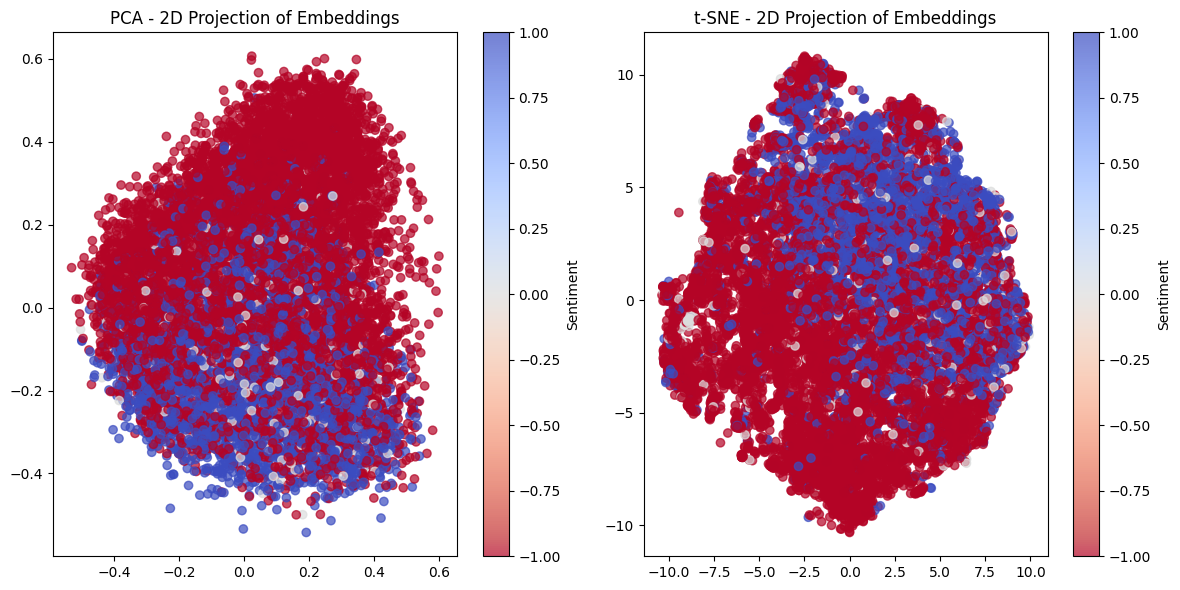

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_np)

# t-SNE for a more detailed 2D visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(embeddings_np)

# Plotting PCA Result
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['user_input_sentiment'].map({'positive': -1, 'negative': 1, 'neutral': 0}), cmap='coolwarm_r', alpha=0.7)
plt.title('PCA - 2D Projection of Embeddings')
plt.colorbar(label='Sentiment')

# Plotting t-SNE Result
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df['user_input_sentiment'].map({'positive': -1, 'negative': 1, 'neutral': 0}), cmap='coolwarm_r', alpha=0.7)
plt.title('t-SNE - 2D Projection of Embeddings')
plt.colorbar(label='Sentiment')

# Display plots
plt.tight_layout()
plt.show()


C:\Users\vaide\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vaide\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vaide\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vaide\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The defa

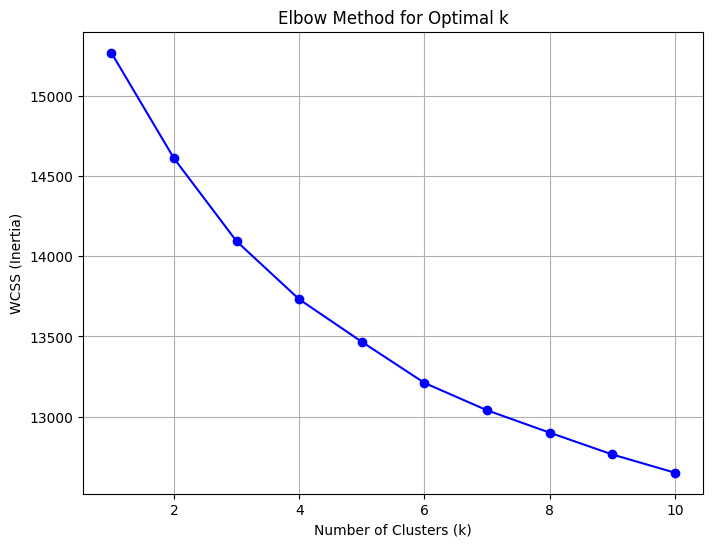

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Range of possible cluster counts
k_range = range(1, 11)  # You can adjust the range (1-10 here, but you can try higher)

# List to store WCSS values for each k
wcss = []

# Loop through the range of k values and calculate inertia for each
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings_np)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()


C:\Users\vaide\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


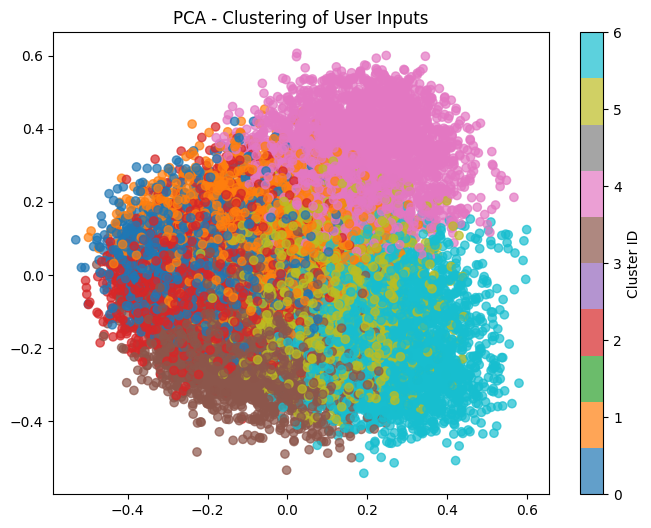

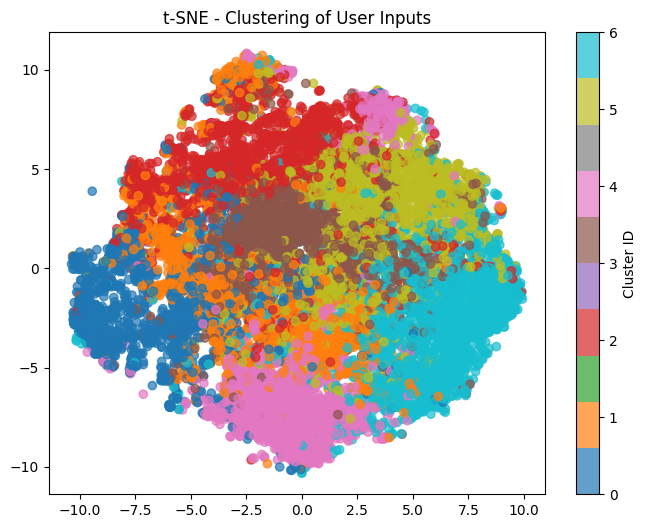

Cluster Centers (Centroids):
[[ 0.01578918  0.00138094  0.04857079 ... -0.00833159 -0.07658882
  -0.00682157]
 [ 0.00028099  0.00191298  0.03679089 ... -0.00101604 -0.04348759
  -0.01033142]
 [ 0.02187483 -0.02673657  0.04719124 ... -0.0124294  -0.07401384
   0.02315043]
 ...
 [-0.00703291 -0.00672226  0.09374325 ... -0.0006536  -0.04444088
   0.02234149]
 [-0.00496141 -0.03090236  0.07423031 ... -0.01293651 -0.0450703
  -0.00479713]
 [ 0.00573099  0.00765447  0.04494321 ...  0.02265478 -0.05946909
   0.00340586]]


In [14]:
from sklearn.cluster import KMeans
import numpy as np

# Number of clusters (adjust as needed based on your dataset size)
num_clusters = 7  # You can change this value to experiment with more clusters

# Apply KMeans clustering on the embeddings
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_np)

# Add the cluster labels to the dataframe
df['cluster'] = clusters

# Visualizing the clusters in the PCA result
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['cluster'], cmap='tab10', alpha=0.7)
plt.title('PCA - Clustering of User Inputs')
plt.colorbar(label='Cluster ID')

# Display the PCA plot
plt.show()

# Visualizing the clusters in the t-SNE result
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df['cluster'], cmap='tab10', alpha=0.7)
plt.title('t-SNE - Clustering of User Inputs')
plt.colorbar(label='Cluster ID')

# Display the t-SNE plot
plt.show()

# Optionally, you can also output the cluster centers
print("Cluster Centers (Centroids):")
print(kmeans.cluster_centers_)


In [16]:
! pip install sentence-transformers
! pip install torch torchvision torchaudio
! pip install transformers
! pip install tensorflow
! pip install tf-keras


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
! pip install transformers torch scikit-learn numpy pandas

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Step 1: Generate embedding for new user input
def generate_embedding_for_input(user_input):
    user_input_embedding = generate_embeddings([user_input])[0]
    return user_input_embedding

# Step 2: Find closest cluster based on centroids
def get_closest_cluster(user_input_embedding, kmeans_model):
    # Get the cluster centroids from the trained KMeans model
    cluster_centroids = kmeans_model.cluster_centers_
    
    # Calculate cosine similarity between the user input embedding and each centroid
    similarities = cosine_similarity([user_input_embedding], cluster_centroids).flatten()
    
    # Get the index of the closest cluster
    closest_cluster_id = similarities.argmax()
    return closest_cluster_id

# Step 3: Retrieve most similar responses for the identified cluster
def get_most_similar_responses(user_input, cluster_id, top_n=3):
    # Generate the embedding for the custom user input
    user_input_embedding = generate_embedding_for_input(user_input)
    
    # Get the embeddings of all bot responses in the selected cluster
    cluster_bot_responses = df[df['cluster'] == cluster_id]['bot_response'].tolist()
    cluster_bot_embeddings = np.array([generate_embeddings([response])[0] for response in cluster_bot_responses])

    # Compute the cosine similarity between the user input and each bot response
    similarities = cosine_similarity([user_input_embedding], cluster_bot_embeddings).flatten()

    # Get the indices of the top-N most similar responses (e.g., top 3)
    top_n_indices = similarities.argsort()[-top_n:][::-1]  # Top N most similar responses
    
    # Get the most similar bot responses
    top_responses = [cluster_bot_responses[i] for i in top_n_indices]
    return top_responses

# Example of custom user input
user_input = "I'm feeling really stressed out at work, what can I do?"

# Step 4: Automatically identify the cluster and get responses
user_input_embedding = generate_embedding_for_input(user_input)
closest_cluster_id = get_closest_cluster(user_input_embedding, kmeans)

# Get the top 3 most similar responses for the identified cluster
top_responses = get_most_similar_responses(user_input, closest_cluster_id, top_n=3)

# Display the top-N responses
print(f"Cluster ID: {closest_cluster_id}")
print("Top 3 most similar bot responses:")
for i, response in enumerate(top_responses, 1):
    print(f"{i}. {response}")

Cluster ID: 2
Top 3 most similar bot responses:
1. it sounds like you're dealing with a lot of pressure at work, attlee. let's explore what we can do to alleviate this stress. have you considered talking to your boss about how you're feeling?
2. hi balliol, i'm really glad you reached out to me. it takes a lot of courage to recognize when you need help. let's talk about your work-related stress and explore how we can manage your expectations in a healthy way. can you tell me more about what specifically is causing you stress at work?
3. hi alegre, it sounds like you're going through a tough time with work-related stress. can you tell me more about what's been happening?
